## Importing MNIST Dataset

In [1]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)   

### Verifiying Dataset Was Loaded Correctly via MnistDataloader class

In [2]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = 'MNIST'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte') #60,000 training images
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte') #10,000 test images
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

print(training_images_filepath)
print(training_labels_filepath)
print(test_images_filepath)
print(test_labels_filepath)

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray) # values go from 0 (black) to 256
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

MNIST\train-images-idx3-ubyte/train-images-idx3-ubyte
MNIST\train-labels-idx1-ubyte/train-labels-idx1-ubyte
MNIST\t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
MNIST\t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte


### Showing Some of the Images Based on Selected File Path

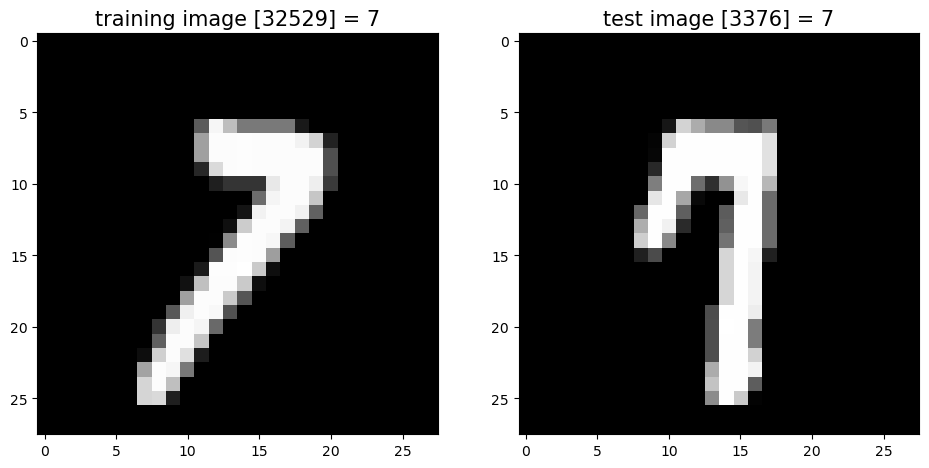

In [3]:
#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 1): # how many random training images you want to show
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 1): # how many random test images you want to show
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

## Creating Neural Network (one hidden layer)

There will be 2 layers, excluding the inputs. The inputs will be 28 * 28 neurons or 784 in total, the hidden layer will have 300 neurons, and then the output will have 10 neurons representing the likihood of each digit in this classification problem after applying the softmax function to the logit function.

In [4]:
#Constructing mini-batch to be input (reused function to get test inputs as well)
def GetMiniBatch(x_train, y_train, numInputs): 
    miniBatch = np.zeros((784,numInputs))
    y_miniBatch = np.zeros((10,numInputs))
    for i in range(numInputs):
        r = random.randint(0, len(x_train) - 1) #we may sample the same images again from another batch but this will be fixed later on
        temp = np.array(x_train[r])
        y_miniBatch[y_train[r],i] = 1 #putting a 1 where the correct label is 
        temp = np.reshape(temp, 784) / 255 #dividing by 255 to change range to [0,1] to prevent overflowing when computing softmax later on
        miniBatch[:,i] = temp
    return miniBatch, y_miniBatch  #each column represents a sample


In [6]:
# Makeshift Gradient Checker used for Debugging where I changed one value in one of the parameters to find derivative of loss w.r.t to that value

# def GradientChecker(miniBatch, y_miniBatch, p, e):
#     W2 = p[0]
#     b2 = p[1]
#     W1 = p[2]
#     b1 = p[3]
    
#     #J(W2 + e)
#     #First Layer
#     tempW1 = np.copy(W1)
#     tempW1[200,200] += e
#     z1 = np.matmul(tempW1, miniBatch) + b1 # (300 X 784) X (784 X 100) + (300 X 1) => (300 X 100)
#     a1 = sigmoid(z1)
#     #Second layer
#     z2 = np.matmul(W2, a1) + b2 # LOGIT: (10 X 300) X (300 X 100) + (10 X 1) => (10 X 100) 
#     #Softmax
#     rows, cols = z2.shape
#     softmax_denominator = np.zeros((rows,cols))
#     for i in range(cols):
#         denominator_sum = np.sum(np.exp(z2[:,i]))
#         softmax_denominator[:,i] = np.full(rows, denominator_sum)
        
#     softmax = np.exp(z2) / softmax_denominator #final output normalized as probabilities
#     loss_1 = Loss(softmax, y_miniBatch)
    
#     #J(W2 - e)
#     #First Layer
#     tempW1 = np.copy(W1)
#     tempW1[200,200] -= e
#     z1 = np.matmul(W1, miniBatch) + b1 # (300 X 784) X (784 X 100) + (300 X 1) => (300 X 100)
#     a1 = sigmoid(z1)
#     #Second layer
#     z2 = np.matmul(W2, a1) + b2 # LOGIT: (10 X 300) X (300 X 100) + (10 X 1) => (10 X 100) 
#     #Softmax
#     rows, cols = z2.shape
#     softmax_denominator = np.zeros((rows,cols))
#     for i in range(cols):
#         denominator_sum = np.sum(np.exp(z2[:,i]))
#         softmax_denominator[:,i] = np.full(rows, denominator_sum)
#     softmax = np.exp(z2) / softmax_denominator #final output normalized as probabilities
#     loss_2 = Loss(softmax, y_miniBatch)

#     return (loss_1 - loss_2)/ (2 * e)


In [7]:
#Cross Entropy Loss for specified minibatch, TODO: change implementation to just mulitply element wise for efficiency
def Loss(softmax, y_miniBatch):
    # Softmax is (10 by 100) while y_miniBatch is (10 by 100) as well where y_miniBatch holds the one hot encoding
    Loss_all_samples = -np.log(np.diag(np.matmul(y_miniBatch.T, softmax))) ## if the true probability distribution is a one hot encoding then formula reduces to -log(y_correct_label) or the negative log likelihood
    return np.sum(Loss_all_samples) / y_miniBatch.shape[1] # loss over multiple samples is the average of all them

In [8]:
def Accuracy(softmax, y_miniBatch):
    correctClassifications = 0
    numInputs = y_miniBatch.shape[1]
    
    maxiumums = np.max(softmax, axis=0)
    for i in range(numInputs):
        if np.dot(y_miniBatch[:,i], softmax[:,i]) == maxiumums[i]:
            correctClassifications += 1
            
    return correctClassifications/numInputs

#Accuracy(np.array([[.2,.4],[.8,.6]]), np.array([[1,0],[0,1]])) -- testing accuracy function

In [9]:
#Activation Functions
def sigmoid(z):
    return (1/(1 + np.exp(-z)))
            
def sigmoidDeriv(z):
    return (1 - sigmoid(z))

def ReLU(z):
    return np.maximum(0,z)

def ReLUDeriv(z):
    boolMask = z > 0
    return boolMask.astype(int)

In [10]:
#Foward  and Backward Propagation (assuming 100 sample inputs)
def ForwardAndBackwardProp(miniBatch, y_miniBatch, p, learning_rate, layers):
    W2 = p[0]
    b2 = p[1]
    W1 = p[2]
    b1 = p[3]
    
    #First Layer
    z1 = np.matmul(W1, miniBatch) + b1
    a1 = ReLU(z1)
    #Second layer
    z2 = np.matmul(W2, a1) + b2 # LOGIT
    #Softmax
    rows, cols = z2.shape
    softmax_denominator = np.zeros((rows,cols))
    for i in range(cols):
        denominator_sum = np.sum(np.exp(z2[:,i]))
        softmax_denominator[:,i] = np.full(rows, denominator_sum)

    softmax = np.exp(z2) / softmax_denominator #final output normalized as probabilities
    #print("Sum of a column in softmax: {}".format(np.sum(softmax[:,2]))) #checking a column of the final output equals 1
    #print(softmax[:,0])
    # Backward Prop (Calculating Gradients)
    num_inputs = miniBatch.shape[1]
    localError_l2 = softmax - y_miniBatch # derivative of the cross entropy loss with respect to z2 assuming only a softmax is done on z2 is the p - y where is p is the logit and y is the one hot vetor for this classification task 
    
    dW2 = np.zeros((layers[2], layers[1]))
    db2 = np.zeros((layers[2], 1))
    db1 = np.zeros((layers[1], 1))
    dW1 = np.zeros((layers[1], layers[0]))
    
    db2 = (np.sum(localError_l2, axis=1)).reshape((10,1)) #Adding up the localerror along each row
    dW2 = np.matmul(localError_l2, a1.T)
    
    localError_l1 = np.multiply(np.matmul(W2.T, localError_l2), ReLUDeriv(z1))
    db1 = (np.sum(localError_l1, axis=1)).reshape((300,1))
    dW1 = np.matmul(localError_l1, miniBatch.T) 
    #Checking Gradient
    #dW1_verified_01 = GradientChecker(miniBatch, y_miniBatch, p, 0.0001)
    #print("This is verified: {}, this is acutal: {}".format(dW1_verified_01, dW1[200,200]/num_inputs))
    
    #Updating Parameters
    derivParam = [dW2, db2, dW1, db1]
    pNew = []
    
    for i in range(len(p)):
        derivParam[i] /= num_inputs     #Since we take an average of the sum of each sample's loss to get overall loss we must divide by number of inputs
        pNew.append(p[i] - (learning_rate * derivParam[i]))
    return pNew, softmax

### Time to train! Putting it all together :)

In [11]:
# Defining parameters in neural network
layers = [784, 300, 10]
neurons_input, neurons_l1, neurons_output = layers[0], layers[1], layers[2]
randomGen = np.random.default_rng(seed=42)
numInputs = 60

#Initialization matters! -- results worse with this initialization
# W2 = randomGen.random((neurons_output, neurons_l1)) # 10 rows, 300 columns
# b2 = randomGen.random((neurons_output, 1))
# W1 = randomGen.random((neurons_l1, neurons_input)) #300 rows, 784 columns
# b1 = randomGen.random((neurons_l1, 1))

W2 = randomGen.uniform(low = -(1/np.sqrt(numInputs)), high = (1/np.sqrt(numInputs)), size = (neurons_output, neurons_l1)) # 10 rows, 300 columns
b2 = randomGen.uniform(low = -(1/np.sqrt(numInputs)), high = (1/np.sqrt(numInputs)), size = (neurons_output, 1))
W1 = randomGen.uniform(low = -(1/np.sqrt(numInputs)), high = (1/np.sqrt(numInputs)), size = (neurons_l1, neurons_input)) #300 rows, 784 columns
b1 = randomGen.uniform(low = -(1/np.sqrt(numInputs)), high = (1/np.sqrt(numInputs)), size = (neurons_l1, 1))

p = [W2, b2, W1, b1]


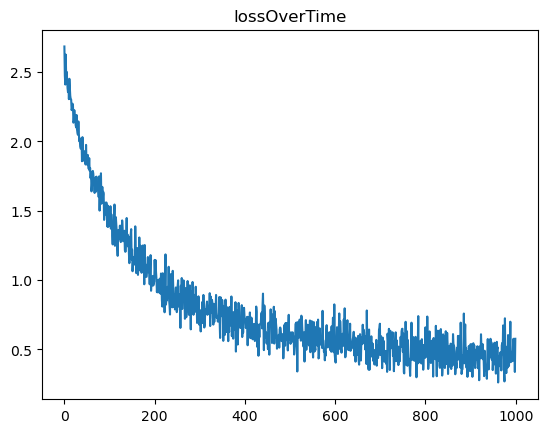

Text(0.5, 1.0, 'accuracyOverTime')

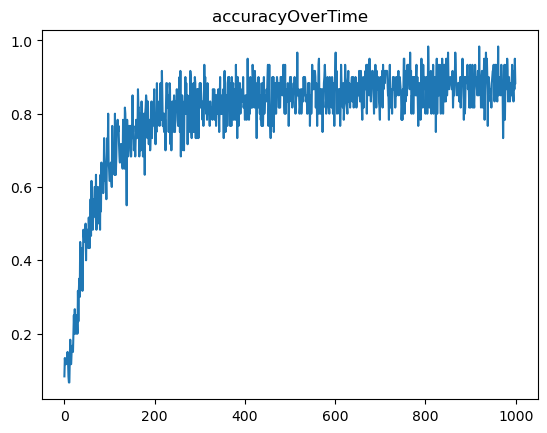

In [12]:
#Training
epochs = 1000
lossOverTime = []
accuracyOverTime = []

for i in range(epochs):
    miniBatch, y_miniBatch = GetMiniBatch(x_train, y_train, numInputs)
    pNew, softmax = ForwardAndBackwardProp(miniBatch, y_miniBatch, p, 0.01, [784,300,10])
    tempLoss = Loss(softmax, y_miniBatch)
    tempAccuracy = Accuracy(softmax, y_miniBatch)
    lossOverTime.append(tempLoss)
    accuracyOverTime.append(tempAccuracy)
    p = pNew
    
plt.plot(lossOverTime)
plt.title("lossOverTime")
plt.show()
plt.plot(accuracyOverTime)
plt.title("accuracyOverTime")

In [13]:
#Testing
testInputs = 10000
test_miniBatch, test_y_miniBatch = GetMiniBatch(x_test, y_test, testInputs)
pNew, softmax = ForwardAndBackwardProp(test_miniBatch, test_y_miniBatch, p, 0.01, [784,300,10])
print("Loss for {} inputs: {}".format(testInputs, Loss(softmax, test_y_miniBatch)))
print("Accuracy for {} inputs: {}".format(testInputs, Accuracy(softmax, test_y_miniBatch)))



Loss for 10000 inputs: 0.43730697555844217
Accuracy for 10000 inputs: 0.8831
